## Set-up

In [1]:
import pandas as pd
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import seaborn as sns
import numpy as np
import random
sns.set_theme()

colors = sns.color_palette("deep")
colormap = ListedColormap([colors[0], colors[1], colors[2]])

In [2]:
def plot_components(H, ax=None, figsize=(10, 6), title='Components found by the NMF', component_names=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    else:
        fig = ax.get_figure()

    n_components = H.shape[0]
    for k in range(n_components):
        if component_names is not None:
            label = component_names[k]
        else:
            label = f'Component {k + 1}'
        ax.plot(H[k, :], marker='o', linestyle='-', label=label)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_title(title)
    ax.legend()

    return fig, ax

In [3]:
def initialize_W(df, X, region_cons_df):
    W = df[['region']]
    W = W.merge(region_cons_df, how='left', left_on='region', right_index=True)
    W.drop('region', axis=1, inplace=True)
    W = W.mul(X.sum(axis=1), axis=0)
    return W

In [4]:
month_mapping = {
    '01': 'January',
    '02': 'February',
    '03': 'March',
    '04': 'April',
    '05': 'May',
    '06': 'June',
    '07': 'July',
    '08': 'August',
    '09': 'September',
    '10': 'October',
    '11': 'November',
    '12': 'December'
}

# Process data

## Data matrix $X$

In [5]:
input_df = pd.read_csv('data/daily_curves.csv', index_col=0)
print(len(input_df))
input_df.head(3)

11653


,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,660.975,648.877,658.723,745.817,773.431,828.180,831.509,758.732,669.630,596.548
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,738.739,678.540,666.579,730.333,764.207,819.056,825.176,754.773,706.062,629.708
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,780.816,845.339,798.132,870.231,891.262,980.735,926.445,845.014,756.975,688.183


In [6]:
unit_info = input_df.index.str.extract(r'^(?P<region>[\w.]+)_(?P<year>\d{4})-(?P<month>\d{2})-\d{2}_(?P<daytype>[\w ]+)$').set_index(input_df.index)
df = pd.concat([input_df, unit_info], axis=1)
# df = df[df.month.isin(months)]
# df = df[(df.month == '10')&(df.daytype=='Working day')]
print(len(df))
df.head(3)

11653


,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,region,year,month,daytype
Calabria_2021-01-02_Saturday,552.943,514.861,462.221,448.924,457.576,462.207,492.594,526.408,579.682,648.228,...,773.431,828.180,831.509,758.732,669.630,596.548,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,518.853,457.879,432.200,419.060,393.992,438.706,462.433,488.501,532.412,641.866,...,764.207,819.056,825.176,754.773,706.062,629.708,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,540.431,450.024,434.019,432.949,435.210,457.071,516.980,625.155,691.067,885.798,...,891.262,980.735,926.445,845.014,756.975,688.183,Calabria,2021,01,Working day


In [7]:
X = df.drop(unit_info.columns, axis=1)
X = X.div(X.sum(axis=1), axis=0)
X.head()

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
Calabria_2021-01-02_Saturday,0.036777,0.034244,0.030743,0.029859,0.030434,0.030742,0.032763,0.035012,0.038555,0.043115,...,0.043962,0.043158,0.043813,0.049605,0.051442,0.055083,0.055305,0.050464,0.044538,0.039677
Calabria_2021-01-03_Holiday,0.034650,0.030578,0.028863,0.027986,0.026312,0.029298,0.030882,0.032623,0.035556,0.042865,...,0.049334,0.045314,0.044515,0.048773,0.051035,0.054698,0.055107,0.050405,0.047152,0.042053
Calabria_2021-01-04_Working day,0.030889,0.025722,0.024807,0.024746,0.024875,0.026124,0.029549,0.035732,0.039499,0.050629,...,0.044629,0.048316,0.045618,0.049739,0.050941,0.056055,0.052952,0.048298,0.043266,0.039334
Calabria_2021-01-05_Working day,0.034875,0.031816,0.029953,0.029646,0.028846,0.030038,0.033733,0.039128,0.043183,0.053717,...,0.044944,0.046061,0.044169,0.047396,0.051299,0.051514,0.050242,0.046238,0.039955,0.035533
Calabria_2021-01-06_Holiday,0.033596,0.029647,0.028442,0.028445,0.027932,0.028731,0.029956,0.032832,0.035834,0.046307,...,0.050172,0.047001,0.044419,0.047253,0.051327,0.052310,0.051003,0.048481,0.044442,0.040235


## Initialization matrices $W_{init}$, $H_{init}$

### Initialize $W$ with year-level sector consumption distribution

In [8]:
cons_df = pd.read_excel('data/consumption/consumption_chart.xlsx')
cons_df.head(3)

,Regione,Settore corretto,Sum of Consumo corretto,year,Zone
0,Veneto,Agricoltura,708.884874,2018,North
1,Veneto,Domestico,5595.518524,2018,North
2,Veneto,Industria,14741.332908,2018,North


In [9]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_cons_df = pd.pivot_table(cons_df[cons_df.year == 2022], values='Sum of Consumo corretto', index='Zone', columns='Settore corretto', aggfunc='sum')
# We remove agriculture since it is too small
region_cons_df.drop('Agricoltura', axis=1, inplace=True)
region_cons_df = region_cons_df.div(region_cons_df.sum(axis=1), axis=0)
region_cons_df.index = region_cons_df.index.str.replace('-', '.')
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [12]:
# Now se should find 4 components (according to the FPCA analysis ran before), so we need to add one more.
# Given that Sardinia and South/Sicily have a similar sector mix with different daily curves and that they seem to differ mainly in type of industry, we choose to split the Industry consumption
# From the industry subsector distribution it seems that the "metalli non ferrosi" is responsible of the deviance of Sardinia from South and Sicily

imcei_df = pd.read_excel('/Users/guillaume/Documents/GitHub/BSS/data/consumption/export_imcei_region_chart.xlsx')
imcei_df.head(3)

,Anno,Mese,Zone,Regione,Settore,Tipo Tensione,Imcei Mensile,Consumi (Gwh)
0,2021,Febbraio,North,Lombardia,SIDERURGIA,AT,56.278856,609.47
1,2021,Febbraio,North,Friuli-Venezia Giulia,SIDERURGIA,AT,16.857709,182.56
2,2021,Febbraio,North,Veneto,SIDERURGIA,AT,16.632398,180.12


In [13]:
# Each year features more or less the same sector distribution, so we take arbtrarily the last year
region_imcei_df = pd.pivot_table(imcei_df, values='Consumi (Gwh)', index='Zone', columns='Settore', aggfunc='sum')
region_imcei_df = region_imcei_df.fillna(0).div(region_imcei_df.fillna(0).sum(axis=1), axis=0)
region_imcei_df

Settore,ALIMENTARE,ALTRI,CARTARIA,CEMENTO CALCE E GESSO,CERAMICHE E VETRARIE,CHIMICA,MECCANICA,METALLI NON FERROSI,MEZZI DI TRASPORTO,SIDERURGIA
Zone,,,,,,,,,,
Calabria,0.000000,0.732288,0.000000,0.181330,0.000000,0.086383,0.000000,0.000000,0.000000,0.000000
Centre-North,0.018280,0.149364,0.256549,0.036830,0.048687,0.101659,0.099522,0.115424,0.031796,0.141888
Centre-South,0.033223,0.225481,0.047489,0.090762,0.013459,0.092326,0.035709,0.071985,0.106571,0.282995
North,0.013951,0.138182,0.009241,0.025275,0.023056,0.092524,0.082830,0.086433,0.018670,0.509838
Sardinia,0.030628,0.060916,0.008278,0.042906,0.000000,0.253736,0.037780,0.565756,0.000000,0.000000
Sicily,0.026833,0.274475,0.000000,0.144020,0.000000,0.181337,0.178375,0.018193,0.007023,0.169744
South,0.103417,0.237429,0.010274,0.209634,0.021636,0.070357,0.011814,0.003816,0.103443,0.228179


In [14]:
# region_cons_df['Industria 2'] = region_imcei_df['METALLI NON FERROSI'] * region_cons_df['Industria']
# region_cons_df['Industria 1'] = region_cons_df['Industria'] - region_cons_df['Industria 2']
# region_cons_df = region_cons_df[['Domestico', 'Servizi', 'Industria 1', 'Industria 2']]
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


In [15]:
skip = True
if not skip:  
    # Let's split the servizi in 2 (maybe for business active during the days and those also active during the evening (like restoration))
    region_cons_df['Servizi 2'] = region_cons_df['Servizi'] / 2
    region_cons_df['Servizi 1'] = region_cons_df['Servizi'] - region_cons_df['Servizi 2']
    region_cons_df = region_cons_df[['Domestico', 'Industria', 'Servizi 1', 'Servizi 2']]
    region_cons_df.index = region_cons_df.index.str.replace('-', '.')
else:
    print("skipped")

skipped


In [16]:
W_init = initialize_W(df, X, region_cons_df)
W_init

,Domestico,Industria,Servizi
Calabria_2021-01-02_Saturday,0.418757,0.169124,0.412119
Calabria_2021-01-03_Holiday,0.418757,0.169124,0.412119
Calabria_2021-01-04_Working day,0.418757,0.169124,0.412119
Calabria_2021-01-05_Working day,0.418757,0.169124,0.412119
Calabria_2021-01-06_Holiday,0.418757,0.169124,0.412119
...,...,...,...
South_2022-12-27_Working day,0.255487,0.467103,0.277410
South_2022-12-28_Working day,0.255487,0.467103,0.277410
South_2022-12-29_Working day,0.255487,0.467103,0.277410
South_2022-12-30_Working day,0.255487,0.467103,0.277410


In [17]:
n_components = 3

### Initialize W with equal values

In [18]:
# /!\ CAUTION /!\: This may cause the algorithm to converge to a local minimum where all the profiles are the same
skip = True
if not skip:
    W_init = pd.DataFrame(index=df.index)
    for k in range(n_components):
        W_init[f'Component {k+1}'] = 1 / n_components
    # Multiply by daily consumption to obtain equal consumption values across components
    W_init = W_init.mul(X.sum(axis=1), axis=0)
    W_init
else:
    print("skipped")

skipped


In [19]:
# Our initial guess for the matrix of components is a constant curve. The condition on the norm of the components being 1 yields S_k = (1/24, ..., 1/24)
H_init = np.ones((n_components, 24)) / 24

# NMF

## Random initialization

840 iterations
3.3923961340563917e-06 error


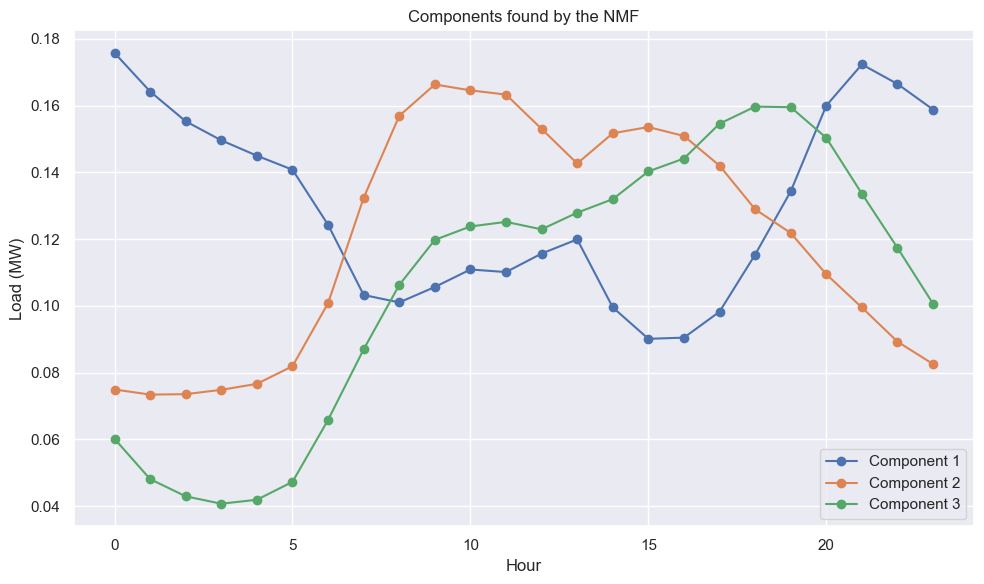

In [23]:
n_components = 3
random_state = None
tol = 1e-5
init = 'random'
max_iter = 4000
solver = 'mu'

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

model = NMF(
    n_components=n_components,
    random_state=random_state,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter
)

W = model.fit_transform(X)
H = model.components_

print('{} iterations'.format(model.n_iter_))
print('{} error'.format(model.reconstruction_err_/X.size))
plot_components(H, ax=axs, title=f"Components found by the NMF")

plt.tight_layout()

## Initialization with year level sector-wise consumption

460 iterations
3.3796031999419833e-06 error


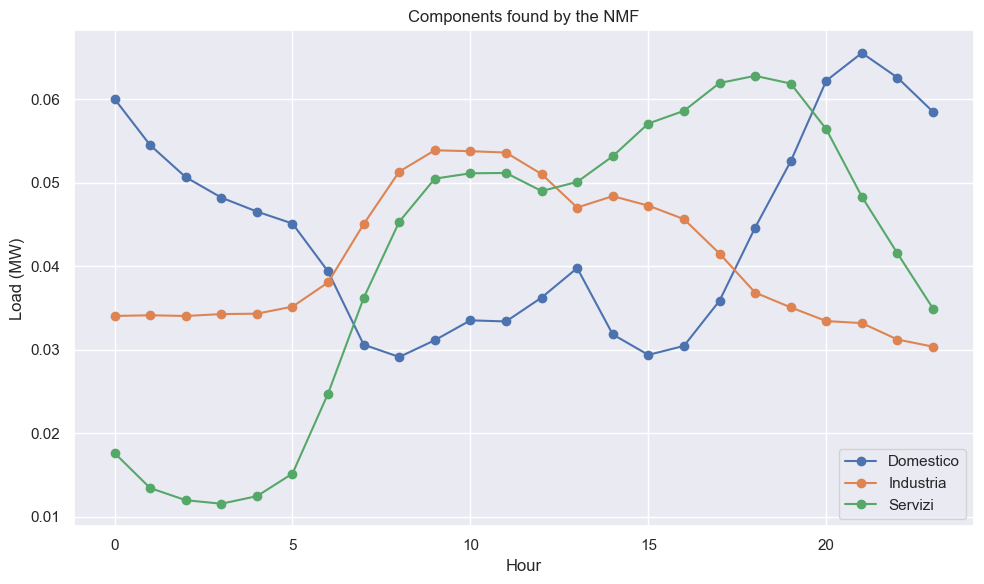

In [49]:
n_components = 3
random_state = None
tol = 1e-5
init = 'custom'
max_iter = 4000
solver = 'mu'
verbose = 0

fig, axs = plt.subplots(1, 1, figsize=(10, 6))

model = NMF(
    n_components=n_components,
    random_state=random_state,
    solver=solver,
    tol=tol,
    init=init,
    max_iter=max_iter,
    verbose=verbose
)

W_init = initialize_W(df, X, region_cons_df)
H_init = np.ones((n_components, 24)) / 24

W = model.fit_transform(
    X.values,
    W=W_init.values.copy(order='C'),
    H=H_init
)

H = model.components_

print('{} iterations'.format(model.n_iter_))
print('{} error'.format(model.reconstruction_err_/X.size))
plot_components(H, ax=axs, title=f"Components found by the NMF", component_names=W_init.columns)
plt.tight_layout()
# plt.savefig('documents/plots/profiles/monthly/month{}_3_sectors_profiles.png'.format('-'.join(months)))

## Analysis of concentrations

In [21]:
W = pd.DataFrame(W, index=df.index, columns=W_init.columns)
W[unit_info.columns] = df[unit_info.columns]
W

,Domestico,Industria,Servizi,region,year,month,daytype
Calabria_2021-01-02_Saturday,0.376135,0.190319,0.427319,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,0.344277,0.148009,0.505020,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,0.192636,0.272233,0.545155,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,0.223220,0.410422,0.371228,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,0.265756,0.275720,0.461955,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...
South_2022-12-27_Working day,0.219615,0.199938,0.587016,South,2022,12,Working day
South_2022-12-28_Working day,0.155432,0.038369,0.820415,South,2022,12,Working day
South_2022-12-29_Working day,0.254855,0.381765,0.366135,South,2022,12,Working day
South_2022-12-30_Working day,0.298268,0.076789,0.627890,South,2022,12,Working day


In [22]:
region_cons_df

Settore corretto,Domestico,Industria,Servizi
Zone,,,
Calabria,0.418757,0.169124,0.412119
Centre.North,0.227537,0.456270,0.316193
Centre.South,0.296825,0.311082,0.392093
North,0.183974,0.520047,0.295979
Sardinia,0.287522,0.439368,0.273110
Sicily,0.342059,0.353885,0.304057
South,0.255487,0.467103,0.277410


Text(0, 0.5, '')

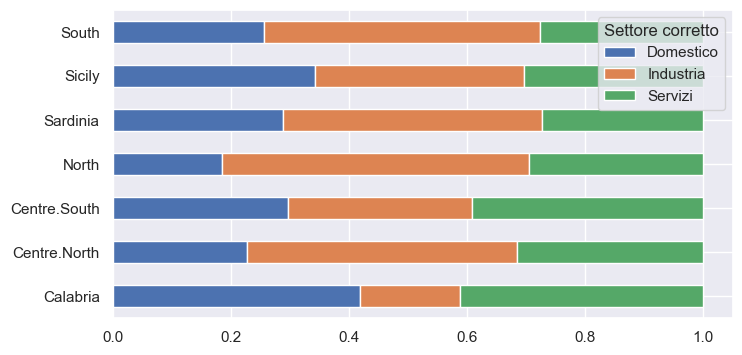

In [29]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
region_cons_df.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

In [23]:
W_region = W.groupby('region')[['Domestico', 'Industria', 'Servizi']].sum()
W_region = W_region.div(W_region.sum(axis=1), axis=0)
W_region

,Domestico,Industria,Servizi
region,,,
Calabria,0.310943,0.324652,0.364405
Centre.North,0.207935,0.452778,0.339287
Centre.South,0.279447,0.339054,0.381499
North,0.203414,0.482923,0.313663
Sardinia,0.311256,0.449295,0.239449
Sicily,0.351322,0.327933,0.320745
South,0.320259,0.367659,0.312082


Text(0, 0.5, '')

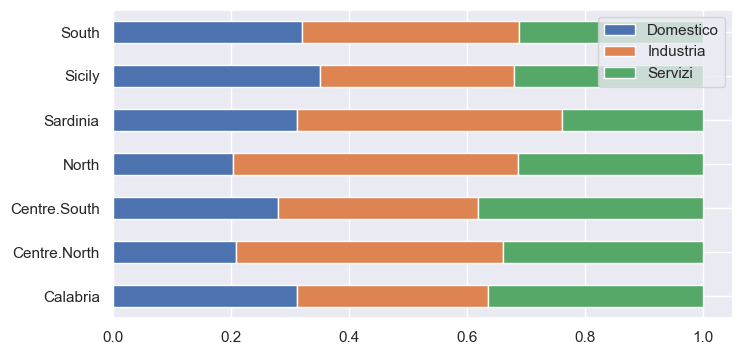

In [30]:
fig, ax = plt.subplots(1, 1, figsize=(8,4))
W_region.plot.barh(stacked=True, ax=ax)
ax.set_ylabel("")

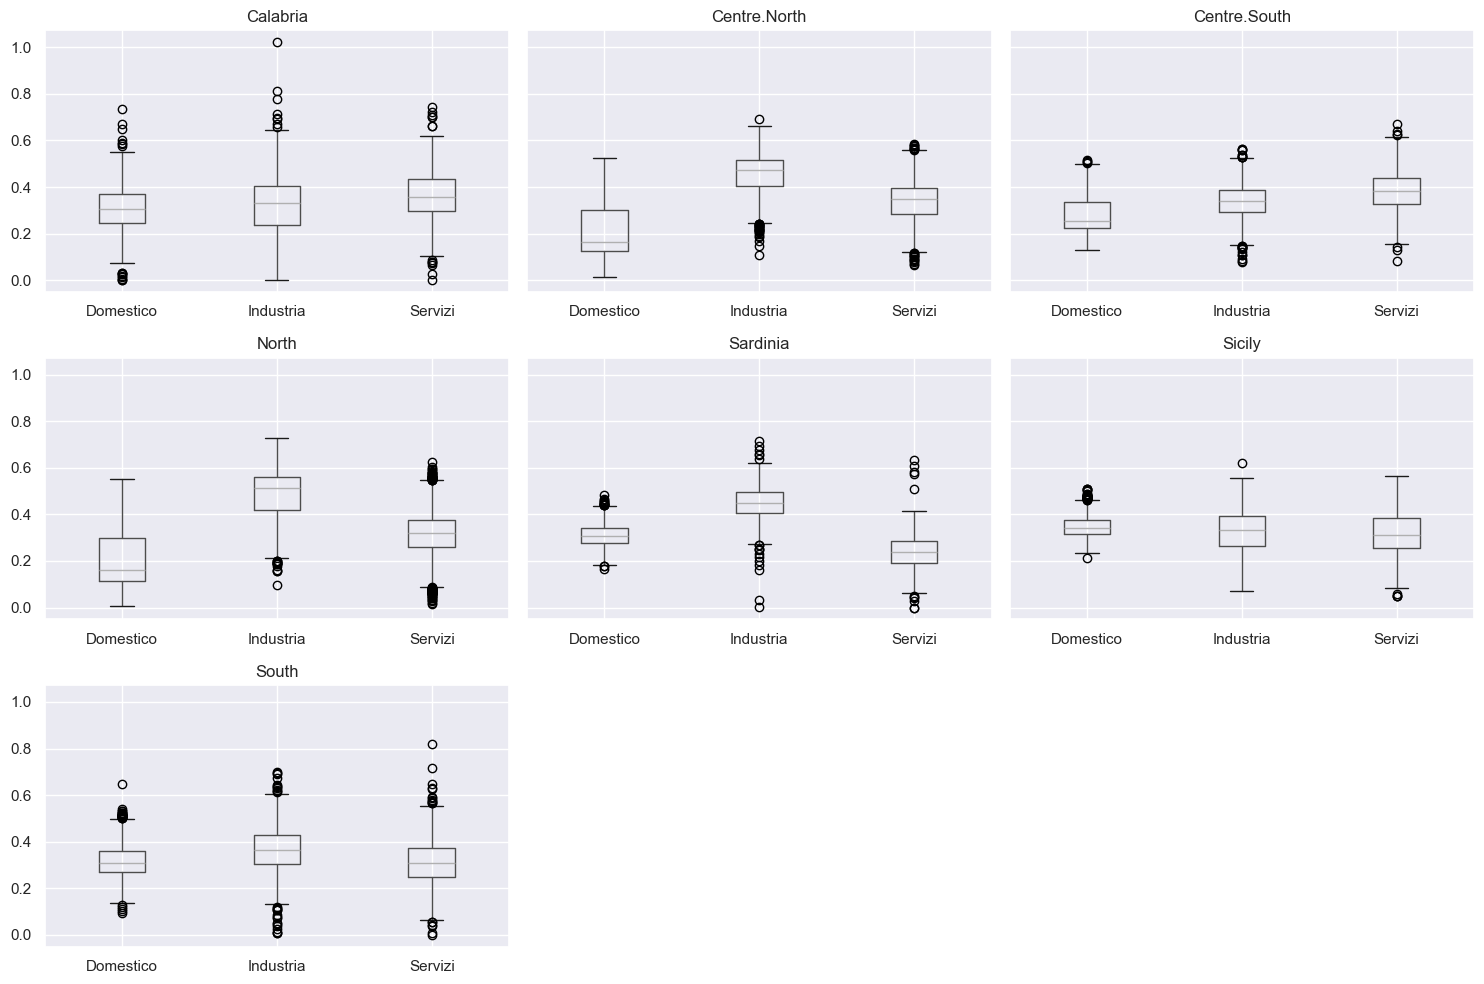

In [31]:
W.groupby('region')[['Domestico', 'Industria', 'Servizi']].boxplot(figsize=(15,10))
plt.tight_layout()

In [24]:
W_daytype = W.groupby('daytype')[['Domestico', 'Industria', 'Servizi']].sum()
W_daytype = W_daytype.div(W_daytype.sum(axis=1), axis=0)
W_daytype

,Domestico,Industria,Servizi
daytype,,,
Holiday,0.402811,0.339420,0.257769
Saturday,0.339403,0.411435,0.249162
Working day,0.240535,0.409826,0.349639


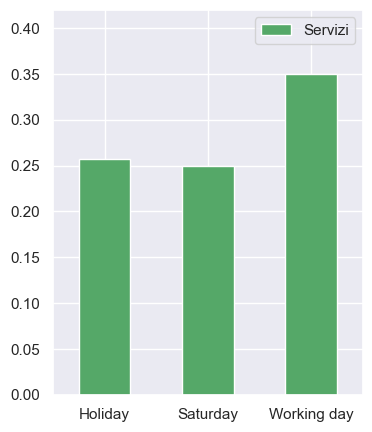

In [48]:
plt.figure(figsize=(4, 5))
W_daytype.Servizi.plot(kind='bar', color=colors[2])
plt.ylim((0,0.42))
plt.xlabel("")
plt.xticks(rotation=0)
plt.legend()

In [32]:
W_daytype = W[W['daytype'] == 'Working day'].groupby(['region', 'month'])[['Domestico', 'Industria', 'Servizi']].sum()
W_daytype = W_daytype.div(W_daytype.sum(axis=1), axis=0).round(2)
# W_daytype
W_daytype.unstack(level='region').T

month                     01    02    03    04    05    06    07    08    09  \
          region                                                               
Domestico Calabria      0.20  0.24  0.29  0.31  0.32  0.29  0.32  0.35  0.30   
          Centre.North  0.11  0.12  0.15  0.17  0.15  0.14  0.14  0.22  0.14   
          Centre.South  0.20  0.23  0.27  0.28  0.25  0.23  0.22  0.27  0.23   
          North         0.09  0.10  0.14  0.16  0.15  0.15  0.16  0.22  0.14   
          Sardinia      0.26  0.28  0.30  0.30  0.30  0.29  0.30  0.35  0.30   
          Sicily        0.32  0.34  0.35  0.35  0.32  0.31  0.34  0.36  0.32   
          South         0.26  0.27  0.32  0.32  0.29  0.28  0.29  0.30  0.29   
Industria Calabria      0.35  0.31  0.29  0.35  0.36  0.34  0.34  0.31  0.36   
          Centre.North  0.46  0.48  0.48  0.48  0.50  0.49  0.48  0.42  0.49   
          Centre.South  0.30  0.31  0.31  0.36  0.40  0.39  0.38  0.37  0.39   
          North         0.51  0.53  0.50  0.51  0.52  0.51  0.50  0.45  0.52   
          Sardinia      0.41  0.43  0.42  0.49  0.52  0.50  0.45  0.42  0.49   
          Sicily        0.22  0.25  0.28  0.35  0.42  0.40  0.38  0.38  0.38   
          South         0.32  0.32  0.33  0.39  0.42  0.42  0.43  0.41  0.42   
Servizi   Calabria      0.45  0.46  0.42  0.34  0.32  0.37  0.34  0.34  0.34   
          Centre.North  0.43  0.40  0.37  0.34  0.36  0.36  0.38  0.36  0.37   
          Centre.South  0.50  0.46  0.42  0.36  0.35  0.38  0.40  0.37  0.39   
          North         0.40  0.38  0.36  0.33  0.34  0.35  0.34  0.33  0.34   
          Sardinia      0.33  0.30  0.28  0.21  0.18  0.21  0.25  0.24  0.21   
          Sicily        0.46  0.41  0.37  0.30  0.26  0.29  0.28  0.27  0.30   
          South         0.42  0.40  0.35  0.29  0.29  0.30  0.29  0.29  0.29   

month                     10    11    12  
          region                          
Domestico Calabria      0.27  0.21  0.24  
          Centre.North  0.14  0.12  0.12  
          Centre.South  0.25  0.22  0.22  
          North         0.12  0.09  0.10  
          Sardinia      0.30  0.28  0.27  
          Sicily        0.32  0.32  0.32  
          South         0.31  0.28  0.26  
Industria Calabria      0.37  0.35  0.38  
          Centre.North  0.48  0.47  0.48  
          Centre.South  0.36  0.32  0.31  
          North         0.51  0.51  0.51  
          Sardinia      0.49  0.44  0.42  
          Sicily        0.36  0.27  0.25  
          South         0.36  0.31  0.31  
Servizi   Calabria      0.36  0.45  0.38  
          Centre.North  0.38  0.42  0.40  
          Centre.South  0.40  0.46  0.47  
          North         0.37  0.41  0.40  
          Sardinia      0.21  0.28  0.31  
          Sicily        0.32  0.41  0.44  
          South         0.33  0.40  0.43

## NMF separately per year and month

350 iterations for year 2021
2.0162842439017747e-05 error

760 iterations for year 2022
2.4820968359502122e-05 error

290 iterations for year 2018
2.1373044284315178e-05 error

350 iterations for year 2019
1.915438741659806e-05 error

320 iterations for year 2020
1.7827873310029324e-05 error

330 iterations for year 2021
2.174992789334239e-05 error

370 iterations for year 2022
2.2620604592634936e-05 error

300 iterations for year 2018
1.987664769024828e-05 error

300 iterations for year 2019
1.9571945128601385e-05 error

320 iterations for year 2020
1.7967610596407666e-05 error

860 iterations for year 2021
3.0627650993856766e-05 error

410 iterations for year 2022
2.4578809326844834e-05 error

440 iterations for year 2018
2.3021413899242847e-05 error

320 iterations for year 2019
1.8320435868580304e-05 error

360 iterations for year 2020
2.2635644459434907e-05 error

310 iterations for year 2021
2.7099439020256315e-05 error

1030 iterations for year 2022
2.4818273242671926e-05 error


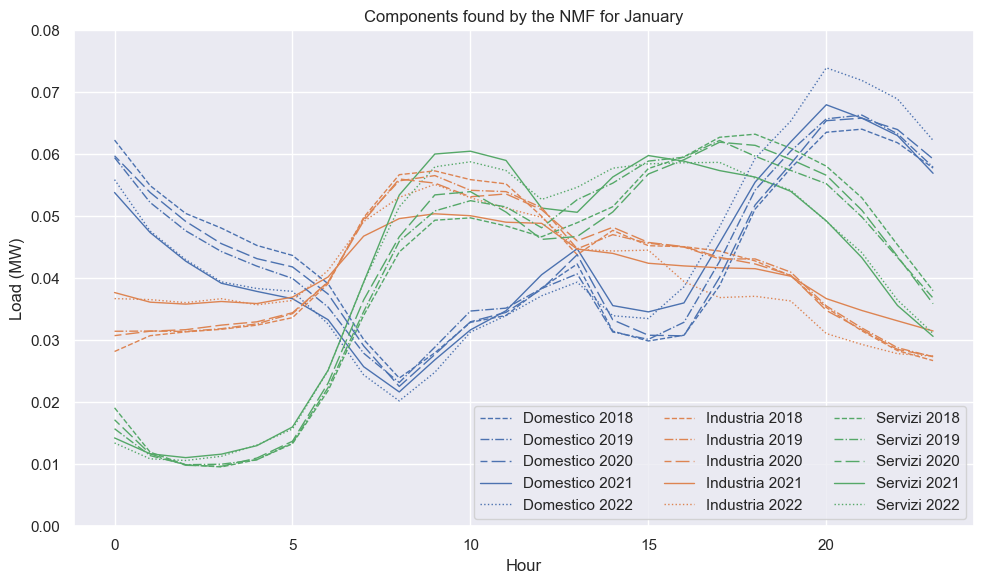

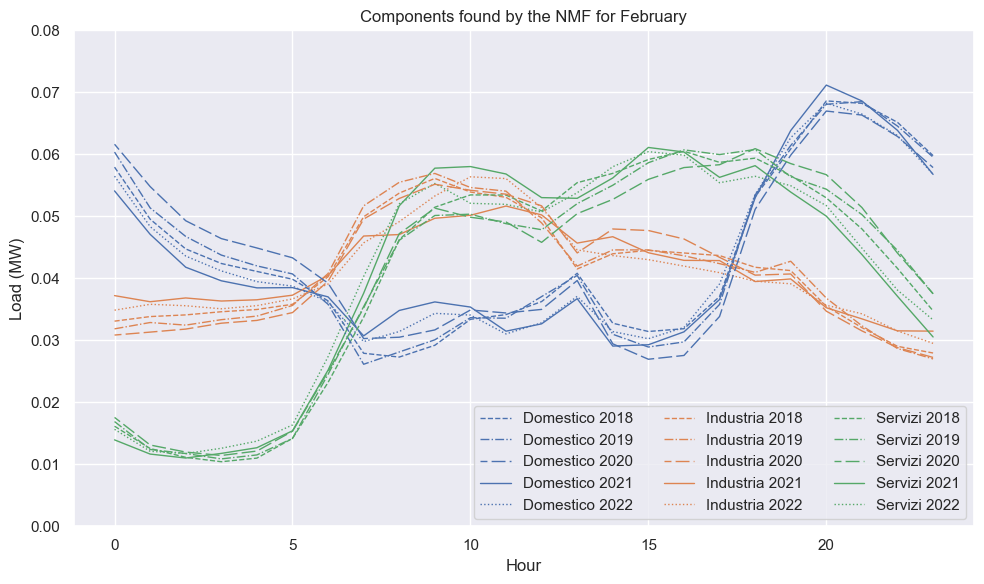

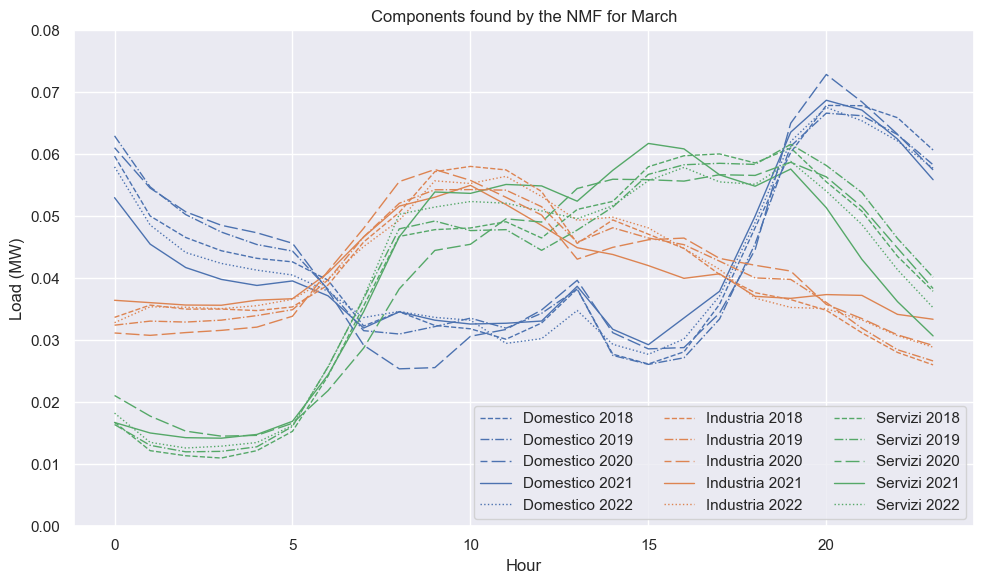

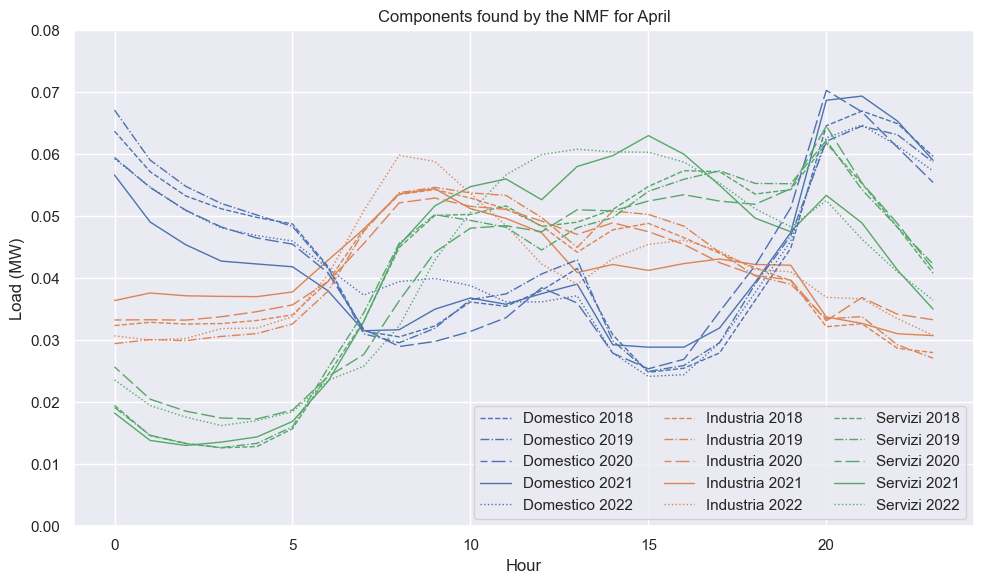

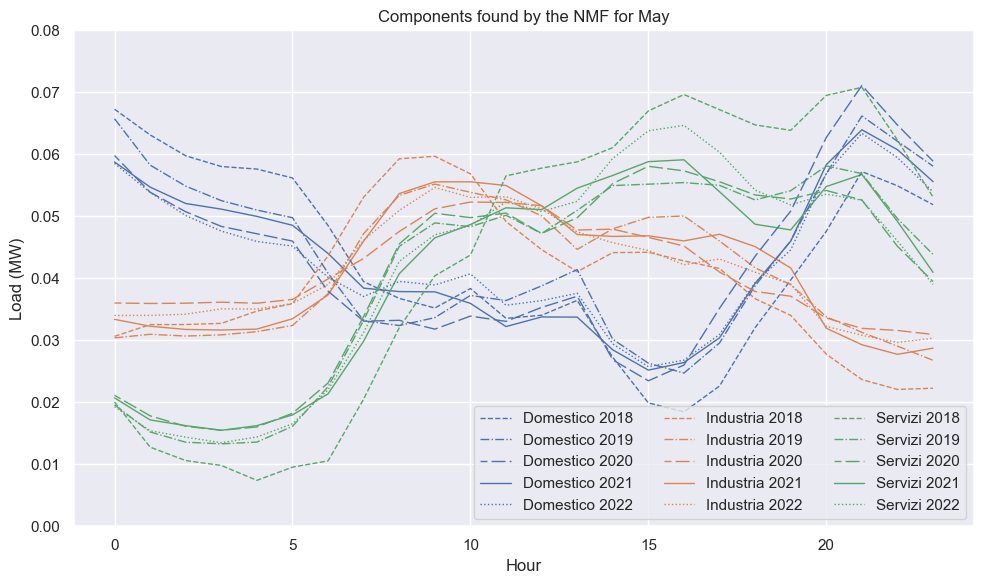

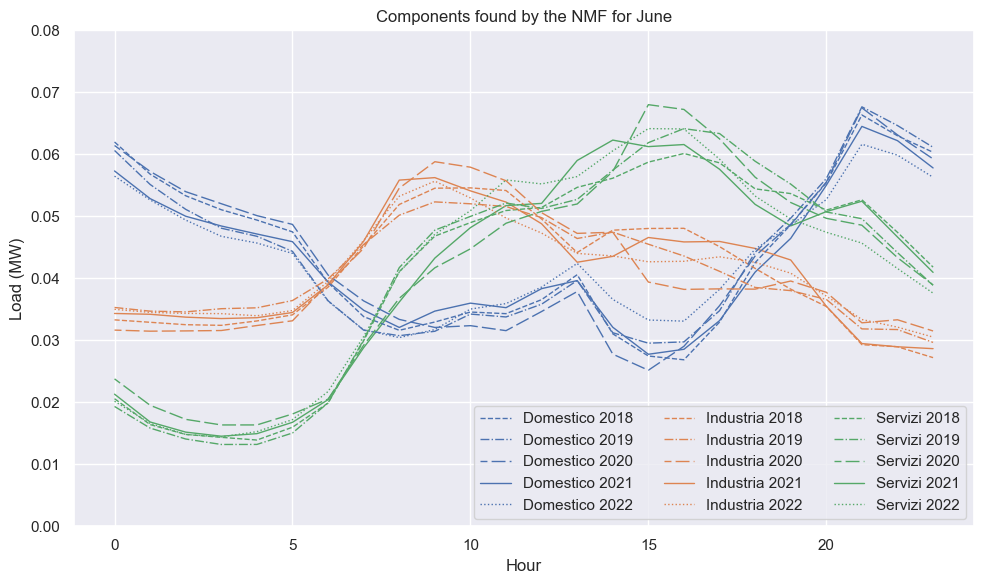

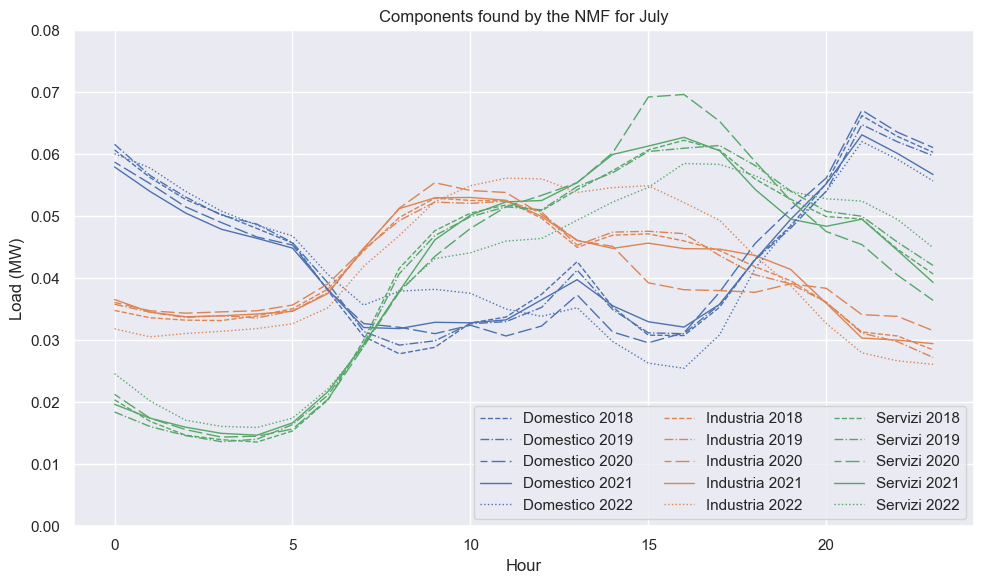

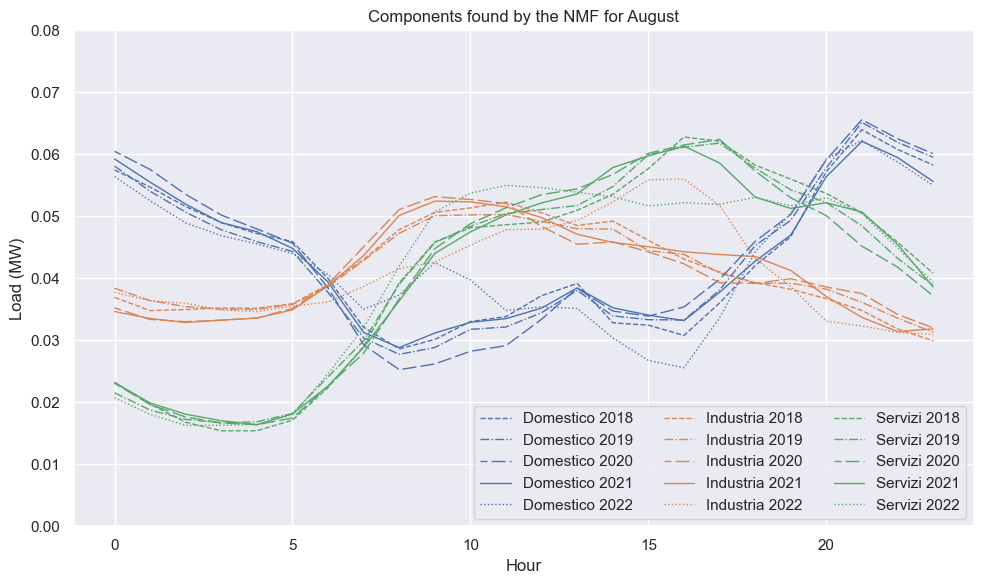

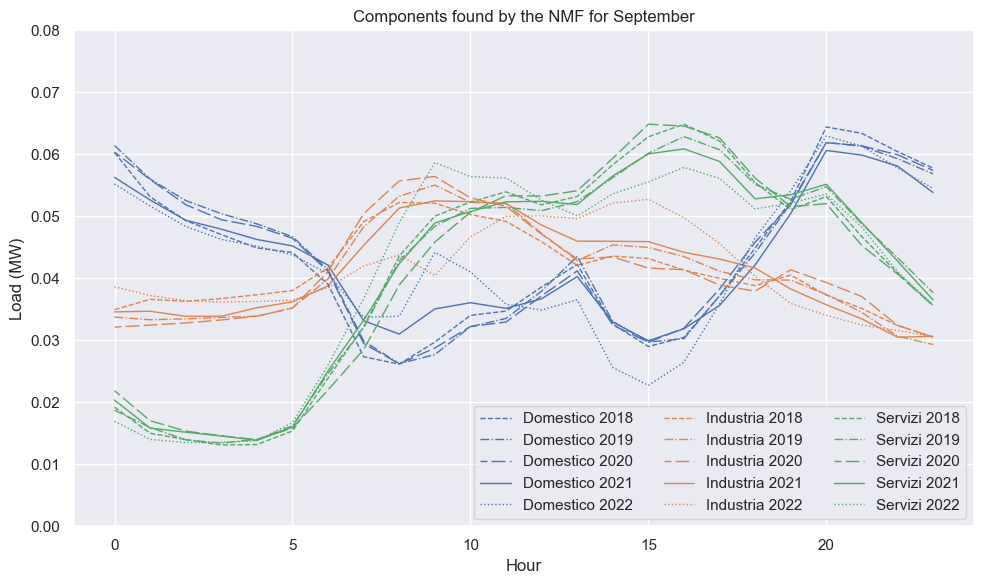

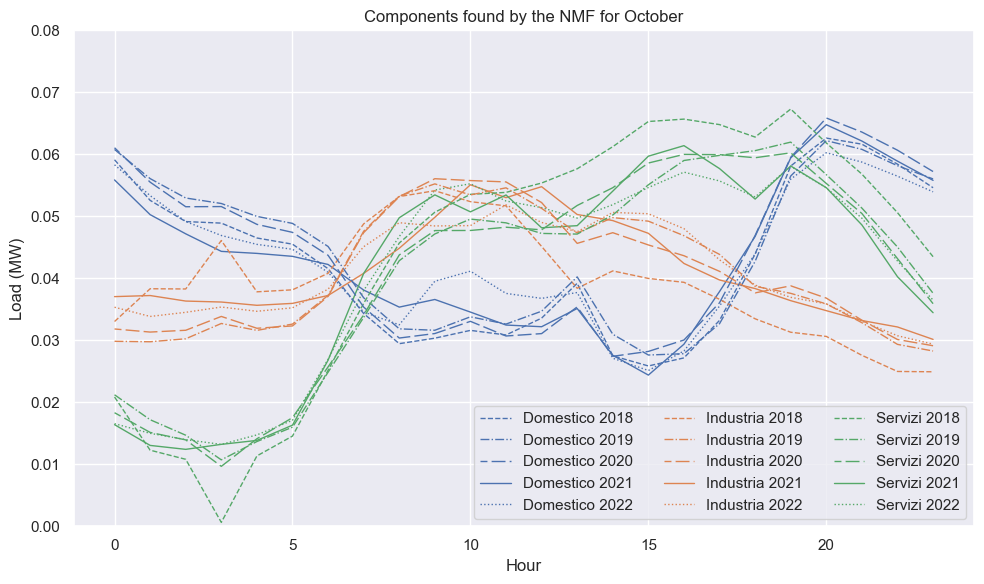

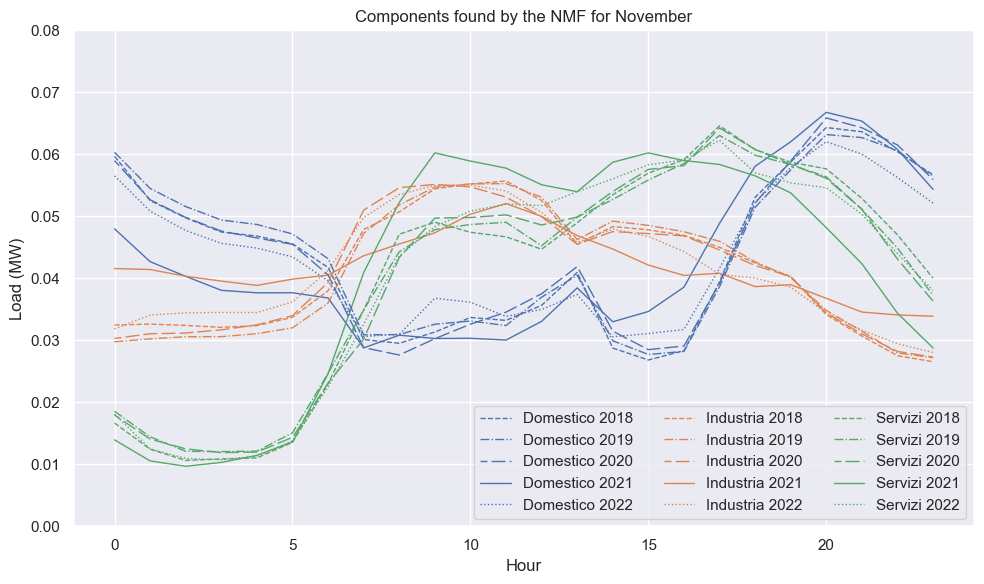

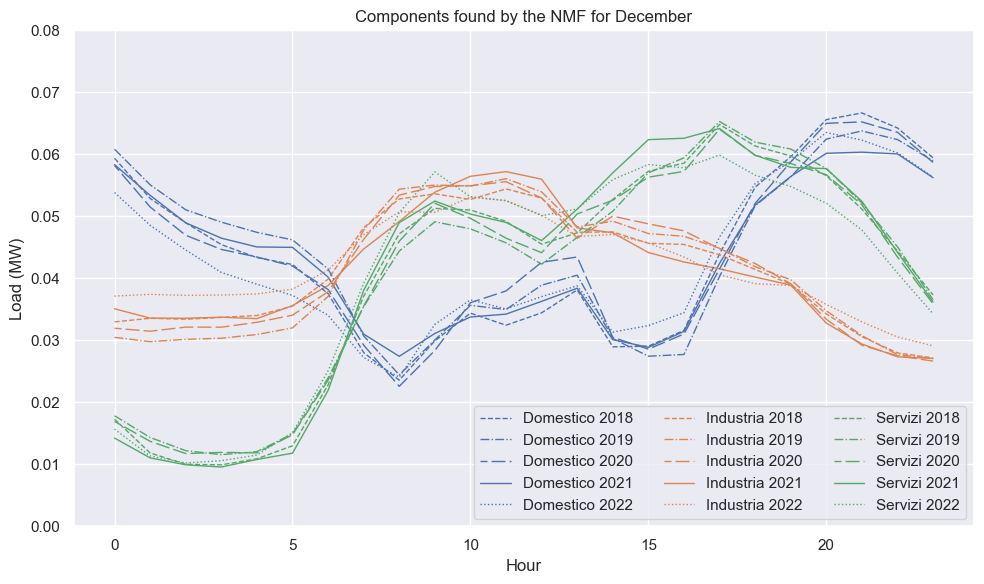

In [39]:
# month = '01'
for month in month_mapping.keys():
    
    df_month = df[df.month == month]
    X_month = X[df.month == month]

    linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3))]
    fig, ax = plt.subplots(figsize=(10, 6))

    legend_entries = []  # To store legend entries for sorting

    for i, year in enumerate(df.year.unique()):

        X_month_year = X_month[df_month.year == year]
        df_month_year = df_month[df_month.year == year]

        W_init_month_year = df_month_year[['region']]
        W_init_month_year = W_init_month_year.merge(region_cons_df, how='left', left_on='region', right_index=True)
        W_init_month_year.drop('region', axis=1, inplace=True)
        W_init_month_year = W_init_month_year.mul(X_month_year.sum(axis=1), axis=0)

        W_init_month_year = initialize_W(df_month_year, X_month_year, region_cons_df)
        H_init = np.ones((n_components, 24)) / 24

        W_month_year = model.fit_transform(
            X_month_year.values,
            W=W_init_month_year.values.copy(order='C'),
            H=H_init
        )

        H_month_year = model.components_

        print('{} iterations for year {}'.format(model.n_iter_, year))
        print('{} error\n'.format(model.reconstruction_err_/X_month_year.size))

        for k, component in enumerate(W_init_month_year.columns):
            line, = ax.plot(H_month_year[k, :], linewidth=1, linestyle=linestyles[i], label=component + ' ' + year, color=colors[k])
            legend_entries.append((component + ' ' + year, line))

    # Sort the legend entries alphabetically
    legend_entries.sort(key=lambda entry: entry[0])

    # Unpack sorted legend entries for plotting
    labels, lines = zip(*legend_entries)

    ax.set_xlabel('Hour')
    ax.set_ylabel('Load (MW)')
    ax.set_ylim((0, .08))
    ax.set_title('Components found by the NMF for {}'.format(month_mapping.get(month)))
    ax.legend(lines, labels, ncol=3, loc='lower right')  # Use the sorted labels and lines for legend


    plt.tight_layout()
    plt.savefig('documents/plots/profiles/month_yearly/{}_{}_3_sectors_profiles.png'.format(month, month_mapping.get(month)))

## NMF separately per year

400 iterations for year 2021
7.914065981027886e-06 error

450 iterations for year 2022
7.812590557663602e-06 error

440 iterations for year 2018
7.239553984569659e-06 error

550 iterations for year 2019
7.067942512616397e-06 error

530 iterations for year 2020
7.077752951949611e-06 error



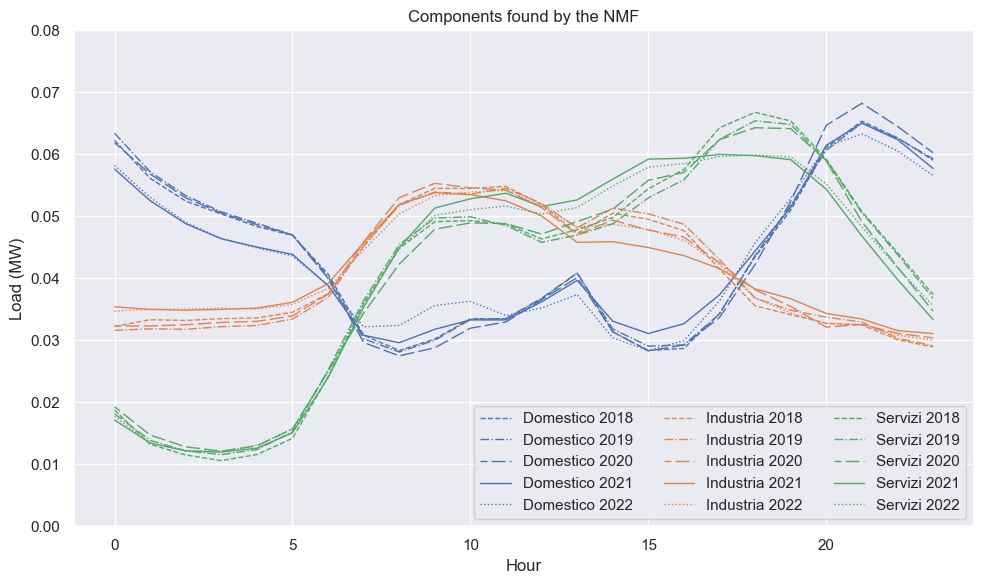

In [40]:
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3)), (0, (5, 10))]
fig, ax = plt.subplots(figsize=(10, 6))

legend_entries = []  # To store legend entries for sorting

for i, year in enumerate(df.year.unique()):

    X_year = X[df.year == year]
    df_year = df[df.year == year]

    W_init_year = initialize_W(df_year, X_year, region_cons_df)
    H_init = np.ones((n_components, 24)) / 24

    W_month_year = model.fit_transform(
        X_year.values,
        W=W_init_year.values.copy(order='C'),
        H=H_init
    )

    H_year = model.components_

    print('{} iterations for year {}'.format(model.n_iter_, year))
    print('{} error\n'.format(model.reconstruction_err_/X_year.size))

    for k, component in enumerate(W_init_year.columns):
        line, = ax.plot(H_year[k, :], linewidth=1, linestyle=linestyles[i], label=component + ' ' + year, color=colors[k])
        legend_entries.append((component + ' ' + year, line))

# Sort the legend entries alphabetically
legend_entries.sort(key=lambda entry: entry[0])

# Unpack sorted legend entries for plotting
labels, lines = zip(*legend_entries)

ax.set_xlabel('Hour')
ax.set_ylabel('Load (MW)')
ax.set_ylim((0, .08))
ax.set_title('Components found by the NMF')
ax.legend(lines, labels, ncol=3, loc='lower right')  # Use the sorted labels and lines for legend


plt.tight_layout()
plt.savefig('documents/plots/profiles/yearly/all_years_3_sectors_profiles.png')

## Trying to shuffle the initial concentrations to look at robustness wrt to initialization

460 iterations
3.3796031999419833e-06 error
760 iterations
3.3821032094987333e-06 error
510 iterations
3.3803219380988558e-06 error
1000 iterations
3.3813476889642e-06 error
700 iterations
3.380962293532429e-06 error
630 iterations
3.381351041893159e-06 error


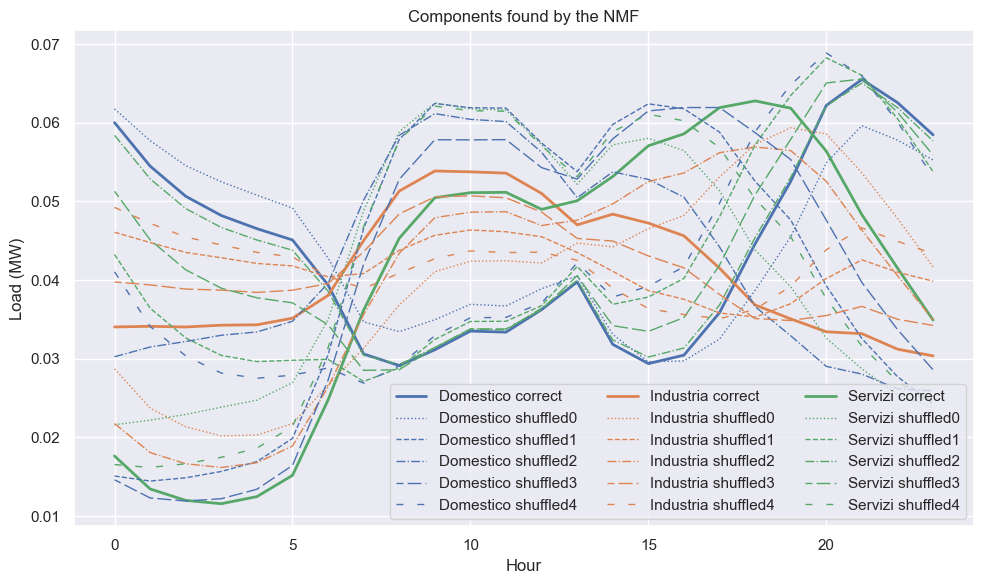

In [21]:
n_components = 3
random_state = None
tol = 1e-5
init = 'custom'
max_iter = 4000
solver = 'mu'

fig, ax = plt.subplots(figsize=(10, 6))
linestyles = ['solid', 'dotted', 'dashed', 'dashdot', (5, (10, 3)), (0, (5, 10))]

n_shuffles = 5

legend_entries = []

for i in range(-1, n_shuffles):

    if i == -1:
        W_init = initialize_W(df, X, region_cons_df)
    else:
        shuffled_index = region_cons_df.index.to_list()
        random.shuffle(shuffled_index)
        shuffled_region_cons_df = pd.DataFrame(region_cons_df.values, index=shuffled_index, columns=region_cons_df.columns)
        W_init = initialize_W(df, X, shuffled_region_cons_df)
    
    H_init = np.ones((n_components, 24)) / 24

    model = NMF(
        n_components=n_components,
        random_state=random_state,
        solver=solver,
        tol=tol,
        init=init,
        max_iter=max_iter
    )

    W = model.fit_transform(
        X.values,
        W=W_init.values.copy(order='C'),
        H=H_init
    )

    H = model.components_

    for k, component in enumerate(W_init.columns):
        if i == -1:
            flag = 'correct'
            linewidth = 2
        else:
            flag = 'shuffled' + str(i)
            linewidth = 1
        label = component + ' ' + flag
        line, = ax.plot(H[k, :], linewidth=linewidth, linestyle=linestyles[i+1], label=label, color=colors[k])
        legend_entries.append((label, line))

    print('{} iterations'.format(model.n_iter_))
    print('{} error'.format(model.reconstruction_err_/X.size))

    # Sort the legend entries alphabetically
legend_entries.sort(key=lambda entry: entry[0])

# Unpack sorted legend entries for plotting
labels, lines = zip(*legend_entries)

ax.set_xlabel('Hour')
ax.set_ylabel('Load (MW)')
# ax.set_ylim((0, .08))
ax.set_title('Components found by the NMF')
ax.legend(lines, labels, ncol=3, loc='lower right')  # Use the sorted labels and lines for legend

plt.tight_layout()

___

# Tests

In [78]:
W_init.columns

Index(['Domestico', 'Industria', 'Servizi'], dtype='object')

In [114]:
# Decompose the load data per sector with the profiles found
k = 2

X = df.drop(unit_info.columns, axis=1)
norm_X = X.sum(axis=1)
W_k = W[:,k]
H_k = H[k,:]

load_k = pd.DataFrame((norm_X * W_k).values.reshape((len(X), 1)).dot(H_k.reshape((1, 24))), columns=range(24), index=X.index)
cons_k = load_k.sum(axis=1)
load_k = pd.concat([load_k, unit_info], axis=1)
cons_k = pd.concat([cons_k, unit_info], axis=1).rename({0: W_init.columns[k]}, axis=1)
load_k

,0,1,2,3,4,5,6,7,8,9,...,18,19,20,21,22,23,region,year,month,daytype
Calabria_2021-01-02_Saturday,113.282431,86.364389,77.013677,74.315438,80.105519,97.475545,159.034583,232.464700,291.118209,324.257936,...,403.302170,397.358942,362.232308,310.313181,266.767950,224.317931,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,133.338314,101.654617,90.648424,87.472481,94.287656,114.732926,187.190574,273.620993,342.658707,381.665597,...,474.704074,467.708638,426.363073,365.252017,313.997400,264.031895,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,168.175187,128.213592,114.331847,110.326135,118.921889,144.708830,236.097254,345.109072,432.184047,481.382142,...,598.728484,589.905372,537.757584,460.680240,396.034493,333.014660,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,112.942478,86.105216,76.782564,74.092423,79.865128,97.183027,158.557331,231.767090,290.244584,323.284861,...,402.091889,396.166496,361.145274,309.381953,265.967399,223.644769,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,126.617791,96.531017,86.079559,83.063689,89.535366,108.950153,177.755787,259.829938,325.388009,362.428873,...,450.778021,444.135169,404.873505,346.842571,298.171291,250.724149,Calabria,2021,01,Holiday
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
South_2022-12-27_Working day,501.285080,382.170294,340.792540,328.852586,354.474222,431.338168,703.742524,1028.677486,1288.224607,1434.870919,...,1784.648858,1758.349531,1602.910975,1373.164106,1180.472493,992.627291,South,2022,12,Working day
South_2022-12-28_Working day,775.664215,591.351773,527.325844,508.850539,548.496216,667.431757,1088.937042,1591.725638,1993.336263,2220.249651,...,2761.479067,2720.784764,2480.266683,2124.767523,1826.605869,1535.943316,South,2022,12,Working day
South_2022-12-29_Working day,318.250285,242.628017,216.358570,208.778265,225.044644,273.843169,446.784210,653.075298,817.853682,910.954857,...,1133.017978,1116.321354,1017.638256,871.779124,749.445220,630.188152,South,2022,12,Working day
South_2022-12-30_Working day,513.059130,391.146608,348.796984,336.576588,362.800018,441.469324,720.271840,1052.838788,1318.482083,1468.572784,...,1826.566214,1799.649175,1640.559720,1405.416618,1208.199115,1015.941855,South,2022,12,Working day


In [115]:
cons_k

,Servizi,region,year,month,daytype
Calabria_2021-01-02_Saturday,6275.478555,Calabria,2021,01,Saturday
Calabria_2021-01-03_Holiday,7386.509324,Calabria,2021,01,Holiday
Calabria_2021-01-04_Working day,9316.358906,Calabria,2021,01,Working day
Calabria_2021-01-05_Working day,6256.646289,Calabria,2021,01,Working day
Calabria_2021-01-06_Holiday,7014.214198,Calabria,2021,01,Holiday
...,...,...,...,...,...
South_2022-12-27_Working day,27769.564542,South,2022,12,Working day
South_2022-12-28_Working day,42969.277025,South,2022,12,Working day
South_2022-12-29_Working day,17630.031651,South,2022,12,Working day
South_2022-12-30_Working day,28421.808658,South,2022,12,Working day


<Axes: xlabel='month'>

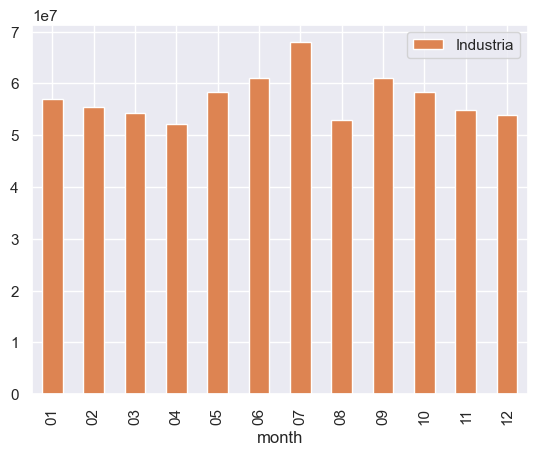

In [107]:
cons_k.groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

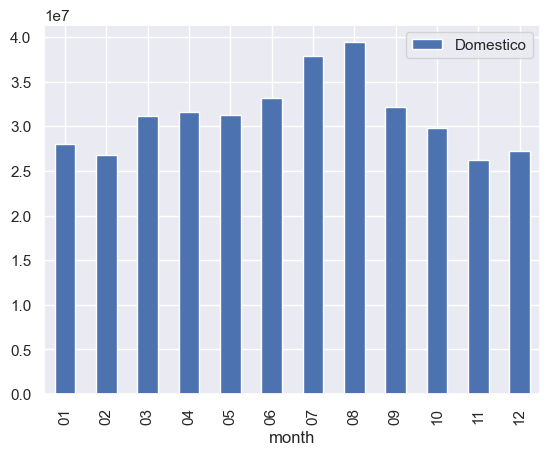

In [112]:
cons_k.groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

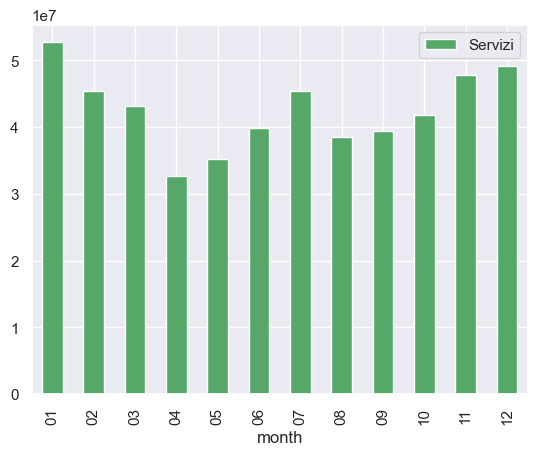

In [116]:
cons_k.groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

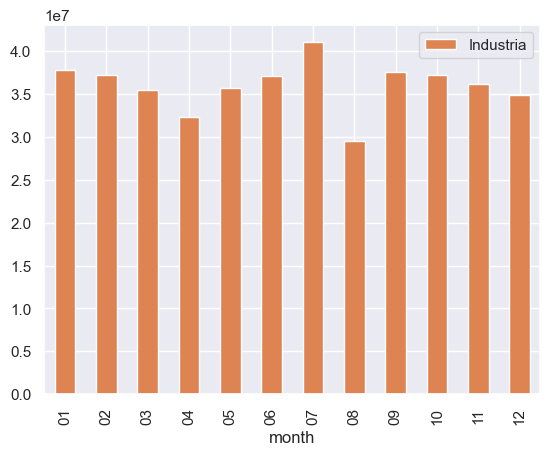

In [109]:
cons_k[cons_k.region=='North'].groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

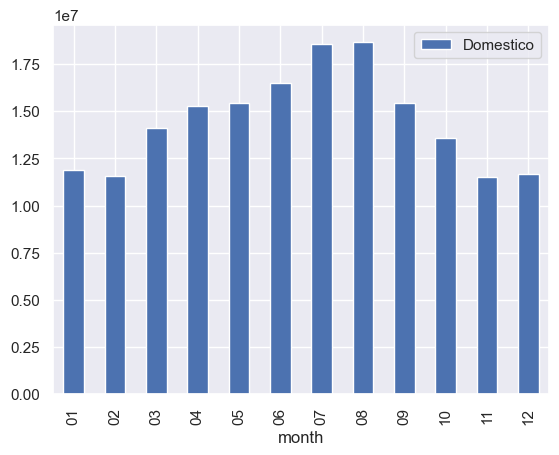

In [113]:
cons_k[cons_k.region=='North'].groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])

<Axes: xlabel='month'>

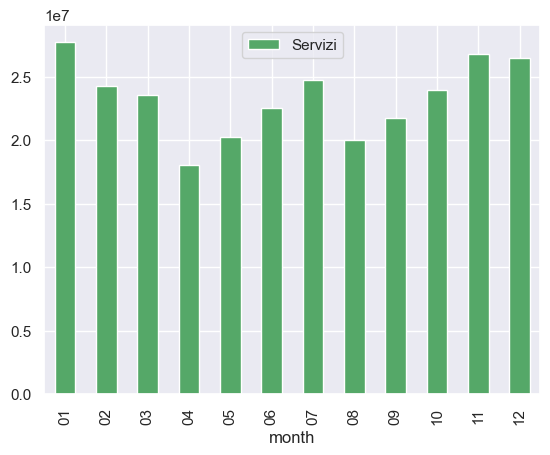

In [117]:
cons_k[cons_k.region=='North'].groupby('month')[W_init.columns[k]].sum().plot(kind='bar', legend=True, color=colors[k])